# PR 8.1 - Regressiemodellen in Machine Learning

Van Pjotr en Sennen

Hierin maken we de opdrachten 8.1 en 8.2. We hebben de opdrachten samen gemaakt en hebben de code ook samen geschreven. We hebben de code in een notebook gezet en de code is uitgevoerd in een Jupyter Notebook.

De opdracht van deze week is:

Great Outdoors wil graag weten hoeveel zij gaat verkopen op basis van een set onafhankelijke variabelen. Daarom wil zij een model trainen op basis van reeds bekende data, zodat deze volgend jaar in gebruik kan worden genomen. Je doet dus het volgende met de reeds bekende data:
- Bedenk met welke onafhankelijke variabelen, die ook uit meerdere databasetabellen kunnen komen, dit naar verwachting het beste voorspeld kan worden en zet deze samen met de afhankelijke variabele in één DataFrame.
- Pas waar nodig Dummy Encoding toe.
- Snijd dit DataFrame horizontaal en verticaal op de juiste manier.
- Train het regressiemodel.
- Evalueer de performance van je getrainde regressiemodel.

#### Wat doen we ermee?
We kunnen met dit model voorspellen hoeveel we gaan verkopen op basis van de onafhankelijke variabelen. Dit kan ons helpen om in te schatten hoeveel we moeten inkopen en hoeveel we moeten produceren. Dit kunnen we bijvoorbeeld gebruiken voor:
- Globaal productverkoop
- Verkoop per productlinie
- Verkoop per individueel product

Hieronder zullen we de libaries importeren die we nodig hebben voor de opdrachten.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import sqlite3

Om te beginnen maken we een connectie naar alle belangrijke data die wij nodig hebben. Zoals inventory, forecast, details en header.

In [2]:
# Deze had ik niet meer nodig.
forecast = pd.read_csv('data/GO_SALES_PRODUCT_FORECASTData.csv', sep=',')
inventory = pd.read_csv('data/GO_SALES_INVENTORY_LEVELSData.csv', sep=',')

# Verbind met de database en haal de tabellen op.
conn = sqlite3.connect('data/go_sales.sqlite')
details = pd.read_sql(con=conn, sql='SELECT * FROM order_details')
header = pd.read_sql(con=conn, sql='SELECT * FROM order_header')
product = pd.read_sql_query("SELECT * FROM product;", conn)

# Drop de kolommen die niet nodig zijn en irrelevant.
details = details.drop(columns=['TRIAL879'])
header = header.drop(columns=['TRIAL885'])

Hierna mergen we de order details en header met elkaar. Dit doen we op basis van de order id. We mergen de inventory met de order details en header op basis van de product id. We mergen de forecast met de inventory op basis van de product id.

In [3]:
order = pd.merge(header, details, on='ORDER_NUMBER')
order

,ORDER_NUMBER,RETAILER_NAME,RETAILER_SITE_CODE,RETAILER_CONTACT_CODE,SALES_STAFF_CODE,SALES_BRANCH_CODE,ORDER_DATE,ORDER_METHOD_CODE,ORDER_DETAIL_CODE,PRODUCT_NUMBER,QUANTITY,UNIT_COST,UNIT_PRICE,UNIT_SALE_PRICE
0,1153,Ultra Sports,4,6,50,18,2020-04-14,7,47747,2,100,9.64,12.53,11.81
1,1153,Ultra Sports,4,6,50,18,2020-04-14,7,47994,32,254,18.25,27.37,25.1
2,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48015,35,114,19.67,26.54,24.82
3,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48022,36,130,21.03,34.9,31.44
4,1153,Ultra Sports,4,6,50,18,2020-04-14,7,48049,39,74,42.33,67.73,61.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43058,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110788,52,64,19,38,33.25
43059,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110816,56,24,9,18,15.75
43060,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110827,57,40,40,80,70
43061,9479,Preben's T°y,338,329,27,15,2022-02-02,5,110914,78,32,79.19,99,94.05


Hier pakken we de kolommen moeten order date converteren.

In [4]:
# Selecteren van onafhankelijke variabelen en afhankelijke variabele
order['YEAR'] = order['ORDER_DATE'].astype(str).str.split("-").str.get(0)
order['MONTH'] = order['ORDER_DATE'].astype(str).str.split("-").str.get(1)
order['MONTH'] = order['MONTH'].str.replace("0","")

# Laat onnodige kolommen vallen
order = order[['PRODUCT_NUMBER', 'QUANTITY', 'YEAR', 'MONTH']]

In dit stukje code wordt er gecontroleerd op ongeldige waarden in onze order dataset. Als er een ongeldige waarde is, dam krijgen we een error.

In [5]:
# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = order[order.isna().any(axis=1) | order.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

order = order.groupby(['PRODUCT_NUMBER', 'YEAR', 'MONTH'])
order = order.aggregate('sum').reset_index()

Hier voeren we een aantal data-verwerkingsstappen uit met behulp van de pandas-bibliotheek.

In [6]:
# Samenvoegen van forecast en inventory data
inventory = inventory.rename(columns={'INVENTORY_MONTH':'MONTH','INVENTORY_YEAR':'YEAR'})
df = pd.merge(forecast, inventory, on=['MONTH', 'YEAR', 'PRODUCT_NUMBER'])

# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = df[df.isna().any(axis=1) | df.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

# Selecteren van onafhankelijke variabelen en afhankelijke variabele
# Product number, quantity, year, month, forecast, inventory
df['PRODUCT_NUMBER'] = df['PRODUCT_NUMBER'].astype(int)
df['MONTH'] = df['MONTH'].astype(int)
df['YEAR'] = df['YEAR'].astype(int)
order['PRODUCT_NUMBER'] = order['PRODUCT_NUMBER'].astype(int)
order['MONTH'] = order['MONTH'].astype(int)
order['YEAR'] = order['YEAR'].astype(int)

df = pd.merge(order, df, on=['MONTH', 'YEAR', 'PRODUCT_NUMBER'])

# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = df[df.isna().any(axis=1) | df.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

Hier pakken we de product uit en zorgen we ervoor dat de product id en de product name in een dataframe komen te staan in de juiste type.

In [7]:
product['PRODUCT_NUMBER'] = product['PRODUCT_NUMBER'].astype(int)
product['PRODUCTION_COST'] = product['PRODUCTION_COST'].astype(float)
product['MARGIN'] = product['MARGIN'].astype(float)
product = product[['PRODUCT_NUMBER', 'PRODUCTION_COST', 'PRODUCT_TYPE_CODE', 'MARGIN']]

df = pd.merge(product, df, on='PRODUCT_NUMBER')

# Bevestig dat er geen null of NaN waardes in de data zitten
bad_data = df[df.isna().any(axis=1) | df.isnull().any(axis=1)]
if len(bad_data) > 0:
    raise ValueError("Ongeldige waardes in brondata van orders")

df

,PRODUCT_NUMBER,PRODUCTION_COST,PRODUCT_TYPE_CODE,MARGIN,YEAR,MONTH,QUANTITY,EXPECTED_VOLUME,INVENTORY_COUNT
0,1,4.0,1,0.33,2020,1,1790,524,2007
1,1,4.0,1,0.33,2020,11,460,390,1829
2,1,4.0,1,0.33,2020,12,872,640,2157
3,1,4.0,1,0.33,2020,2,344,403,2263
4,1,4.0,1,0.33,2020,3,898,750,1965
...,...,...,...,...,...,...,...,...,...
3543,99,2.0,17,0.60,2022,5,466,519,5163
3544,99,2.0,17,0.60,2022,6,598,701,4565
3545,99,2.0,17,0.60,2022,7,264,327,4301
3546,99,2.0,17,0.60,2022,8,264,299,4037


Hier wordt een dataset voorbereid voor verdere analyse, waar we de order details en header samenvoegen. Daarna maken we ook nog dummie data aan via maand en product type.

In [8]:
df['MONTH'] = df['MONTH'].astype(str)
month_dummies = pd.get_dummies(df.loc[:,['MONTH']])

df = pd.concat([df, month_dummies], axis=1)
df.drop(['MONTH'], axis=1)


df['PRODUCT_TYPE_CODE'] = df['PRODUCT_TYPE_CODE'].astype(str)
product_line_dummies = pd.get_dummies(df.loc[:,['PRODUCT_TYPE_CODE']])

df = pd.concat([df, product_line_dummies], axis=1)
df.drop(['PRODUCT_TYPE_CODE'], axis=1)

df.drop(['PRODUCT_NUMBER'], axis=1)

df = df.rename(columns=str.lower)

Nu gaan we de tabellen vertical en horizontaal snijden. We maken een tabel met de onafhankelijke variabelen en een tabel met de afhankelijke variabelen. de afhankelijke variabele is de order quantity en de onafhankelijke variabelen zijn de product type en de maand.

In [9]:
x = df.drop('quantity', axis=1)
y = df.loc[:,['quantity']]
x

,product_number,production_cost,product_type_code,margin,year,month,expected_volume,inventory_count,month_1,month_11,...,product_type_code_2,product_type_code_20,product_type_code_21,product_type_code_3,product_type_code_4,product_type_code_5,product_type_code_6,product_type_code_7,product_type_code_8,product_type_code_9
0,1,4.0,1,0.33,2020,1,524,2007,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,4.0,1,0.33,2020,11,390,1829,False,True,...,False,False,False,False,False,False,False,False,False,False
2,1,4.0,1,0.33,2020,12,640,2157,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,4.0,1,0.33,2020,2,403,2263,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1,4.0,1,0.33,2020,3,750,1965,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3543,99,2.0,17,0.60,2022,5,519,5163,False,False,...,False,False,False,False,False,False,False,False,False,False
3544,99,2.0,17,0.60,2022,6,701,4565,False,False,...,False,False,False,False,False,False,False,False,False,False
3545,99,2.0,17,0.60,2022,7,327,4301,False,False,...,False,False,False,False,False,False,False,False,False,False
3546,99,2.0,17,0.60,2022,8,299,4037,False,False,...,False,False,False,False,False,False,False,False,False,False


Nu gaan we de data trainenen en testen. We maken een train en test set aan. We trainen de data en voorspellen de data. Voor beide x en y.

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42)

Met de training data en de test data gesplitst en getrained, gaan we nu beginnnen aan het maken van een model.

In [11]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(x_train,y_train)
reg_model

LinearRegression()

Hier gaan we met het gegeven regressiemodel de data voorspellen en kijken hoe goed het model is. Dat zullen we later laten zien.

In [12]:
y_pred = reg_model.predict(x_test)
y_pred

array([[-5.79997634e+01],
       [ 2.31817575e+02],
       [ 1.90393792e+03],
       [ 1.40968175e+02],
       [ 5.93247462e+02],
       [ 1.41402910e+03],
       [ 1.82714436e+02],
       [ 4.32819804e+02],
       [ 6.62671059e+02],
       [ 1.70934357e+03],
       [ 2.26925634e+03],
       [ 9.88320898e+01],
       [ 3.71300411e+02],
       [ 2.04463008e+03],
       [ 1.57033650e+03],
       [ 2.15561621e+02],
       [-9.17417478e+00],
       [ 2.11967090e+02],
       [ 5.23274926e+02],
       [ 1.76159203e+03],
       [ 2.70034614e+02],
       [ 1.21096970e+03],
       [ 1.12428907e+03],
       [ 5.59871410e+02],
       [ 1.66460839e+03],
       [ 3.37970298e+02],
       [ 5.99322138e+00],
       [ 1.31398832e+03],
       [ 9.61774976e+02],
       [ 5.20202149e+02],
       [ 9.30755475e+02],
       [-3.74321149e+00],
       [ 1.54322401e+02],
       [ 5.47433651e+02],
       [ 4.20187648e+02],
       [ 8.33265452e+02],
       [ 4.03149513e+02],
       [-6.43872371e+01],
       [ 3.1

De voorspellingen zijn gedaan en worden nu in een dataframe omgezet, we veranderen de naam van een van de kolomen naar 'Predicted_Quantity'.

In [13]:
prediction_df = pd.DataFrame(y_pred)
prediction_df = prediction_df.rename(columns={0: 'predicted_quantity'})
prediction_df

,predicted_quantity
0,-57.999763
1,231.817575
2,1903.937916
3,140.968175
4,593.247462
...,...
528,229.524729
529,1792.862472
530,251.132281
531,643.421570


Hierin worden de voorspellingen met de test data toegevoegd en wordt daarna gecheckt of de predicted_quantity niet null of NaN is.

In [14]:
y_test_prediction_merge = pd.concat([y_test.reset_index()['quantity'], prediction_df], axis=1)
y_test_prediction_merge.loc[y_test_prediction_merge['predicted_quantity'].notna(),:]

,quantity,predicted_quantity
0,44,-57.999763
1,312,231.817575
2,1940,1903.937916
3,202,140.968175
4,748,593.247462
...,...,...
528,266,229.524729
529,3906,1792.862472
530,336,251.132281
531,628,643.421570


Nu wordt het regressie model in beeld gebracht. Nu zal via de grafiek te zien zijn hoe goed het model is. Dit doen we door gebruik te maken van pyplot en seaborn.

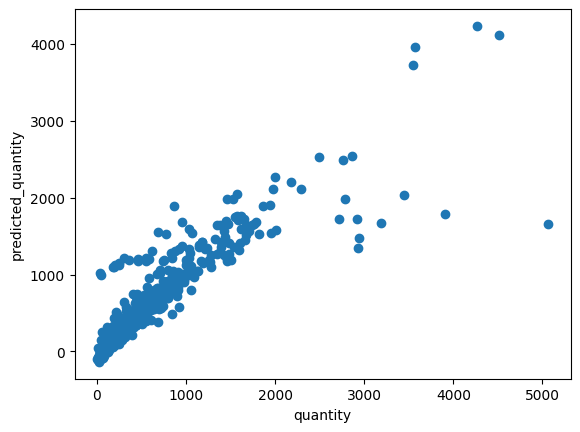

In [15]:
plt.scatter(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])
plt.xlabel('quantity')
plt.ylabel('predicted_quantity')
plt.show()

Met deze functie gaan we de gemiddelde kwadratische fout berekenen.

In [16]:
mean_squared_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

95433.35901501372

Hieronder doen we ook nog het absolute gemiddelde fout berekenen.

In [17]:
mean_absolute_error(y_test_prediction_merge['quantity'], y_test_prediction_merge['predicted_quantity'])

150.0081513783273